<a id="introduction" ></a>
# Introduction

In this notebook, I will use only one model for the following tasks:
- Filling missing values with LGBM regressor
- Building model to predict OUTCOME with LGBM classifier

LightGBM is an ensembling model, which involves sequentially training models, where each new model focuses on the data points that were misclassified by previous models. The difference between LightGBM and XGBoost is:

- XGBoost uses a level-wise tree growth algorithm, where it splits the tree level by level. 
    
- LightGBM employs a leaf-wise (best-first) tree growth algorithm, where it chooses the leaf it believes will yield the best split next, regardless of the level of the tree.
    
In short, the difference between them is similar to breadth-first-search and depth-first-search in graph theory. That's why LGBM is very fast compared to XGBoost.

## Table of Contents
1. [Introduction](#introduction)
2. [Data loading](#data-load)
3. [A first look at missing values](#missing-value)
4. [Fill missing values on training set](#train-fill)
5. [Data analysis](#eda)
    - 5.1 [Univariate analysis](#univariate)
    - 5.2 [Bivariate analysis](#bivariate)
6. [LightGBM Model on training and validation data](#train-and-validate)
7. [Prepare the test set](#prepare-test)
8. [LGBM on test set](#model-on-test)
9. [Hypertuning](#hypertune)
10. [Important features](#features)
11. [Conclusion](#conclusion)

<a id="data-load" ></a>
# Data loading

In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [61]:
df = pd.read_csv('data/Car_Insurance_Claim.csv')

In [62]:
df.shape

(10000, 19)

In [63]:
df.describe()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,290030.768758,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


***Note***

DUIS: Driving Under the Influence (alcohol, drgus)

In [64]:
df.dtypes

ID                       int64
AGE                     object
GENDER                  object
RACE                    object
DRIVING_EXPERIENCE      object
EDUCATION               object
INCOME                  object
CREDIT_SCORE           float64
VEHICLE_OWNERSHIP      float64
VEHICLE_YEAR            object
MARRIED                float64
CHILDREN               float64
POSTAL_CODE              int64
ANNUAL_MILEAGE         float64
VEHICLE_TYPE            object
SPEEDING_VIOLATIONS      int64
DUIS                     int64
PAST_ACCIDENTS           int64
OUTCOME                float64
dtype: object

From the datacard, the following features can be considered categorical: AGE, GENDER, RACE, DRIVING_EXPERIENCE, EDUCATION, INCOME, VEHICLE_OWNERSHIP, VEHICLE_YEAR, MARRIED, CHILDREN, POSTAL_CODE, VEHICLE_TYPE, POSTAL_CODE

he following features can be considered numerical: CREDIT_SCORE, ANNUAL_MILEAGE, SPEEDING_VIOLATION, DUIS, PAST_ACCIDENTS

In [65]:
# Drop the id features
df.drop(columns=['ID'], axis=1, inplace=True)

In [66]:
cat_features = ['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME', 
                'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR', 'MARRIED', 'CHILDREN', 'POSTAL_CODE', 
                'VEHICLE_TYPE']

num_features = ['CREDIT_SCORE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']

<a id="missing-value" ></a>
# A first look at missing values

In [67]:
df.isna().sum()

AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

There 982 missing values for credit score and 957 for annual_mileage.

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='CREDIT_SCORE', ylabel='Count'>

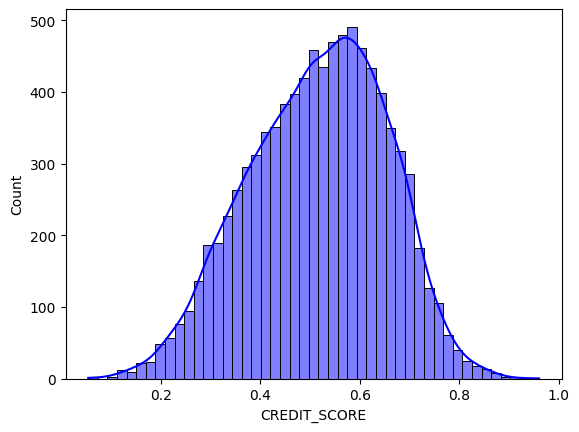

In [69]:
sns.histplot(
    data = df,
    x = 'CREDIT_SCORE',
    kde = True,
    color = 'blue'
)

The histplot looks reasonable symmetric and bell-shaped. We can consider filling missing values by mean fill. There are two common methods to fill missing values:

Mean Fill
- Mean fill involves replacing missing values in a column with the mean (average) of the non-missing values in that column.
- It's well-suited for data that is normally distributed or does not have significant outliers, as the mean is sensitive to outliers.
- It can be used to maintain the overall mean of the dataset, but it might not be the best choice if the data contains outliers, as it can skew the distribution.

Median Fill
- Median fill involves replacing missing values with the median of the non-missing values in the column.
- It is more robust to outliers compared to mean fill. The median is the middle value when the data is sorted, so it's less affected by extreme values.
- Median fill is preferable in datasets with outliers or a skewed distribution, as it preserves the central tendency without being influenced by the outliers.

But ***note that*** domain knowledge is often crucial for making informed decisions about how to handle missing data, especially when considering techniques that involve grouping data.

For more advanced methods, we can use tree-based methods to impute missing values. Tree-based methods are very efficent for tabular data.

<Axes: xlabel='ANNUAL_MILEAGE', ylabel='Count'>

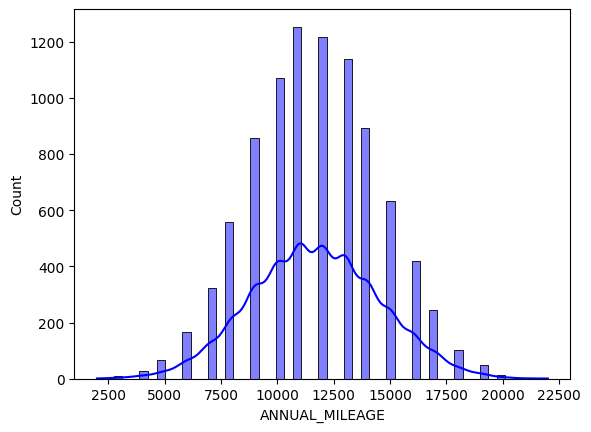

In [70]:
sns.histplot(
    data = df,
    x = 'ANNUAL_MILEAGE',
    kde = True,
    color = 'blue'
)

<Axes: xlabel='ANNUAL_MILEAGE', ylabel='Count'>

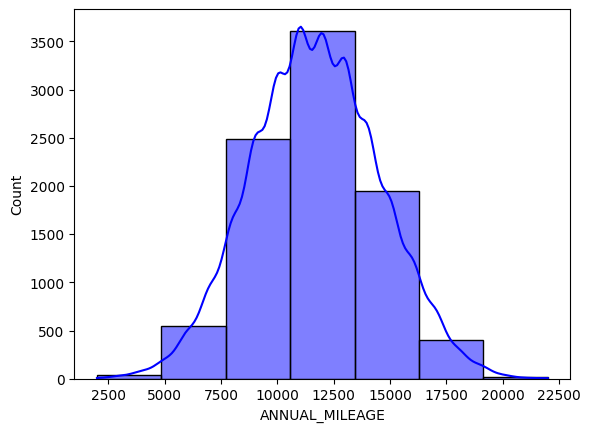

In [71]:
sns.histplot(
    data = df,
    x = 'ANNUAL_MILEAGE',
    bins = 7,
    kde = True,
    color = 'blue'
)

From the plot, we can see that ANNUAL_MILEAGE has

- Multi-modal Distribution: The histogram shows several peaks, suggesting that the data may be multi-modal. This could indicate the presence of distinct groups within the dataset that have different driving habits or vehicle usage patterns. For example, one peak might represent city dwellers who typically drive fewer miles, while another peak might represent suburban or rural residents who tend to drive more.

- Skewness: The distribution appears to be right-skewed, meaning there are a tail and outliers on the higher end of annual mileage. This skewness implies that while most people drive a moderate amount, there is a smaller number of individuals who drive significantly more than average.

We will use Light GBM to fill missing values

<Axes: xlabel='ANNUAL_MILEAGE'>

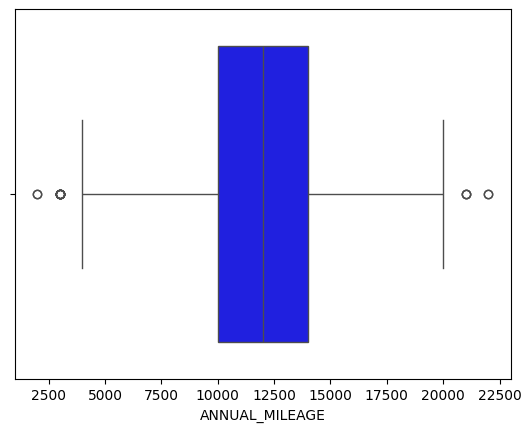

In [72]:
sns.boxplot(
    data = df,
    x = 'ANNUAL_MILEAGE',
    color = 'blue'
)

There are a few outliers for ANNUAL_MILEAGE, but I won't remove them to see the predictive power of the models.

<a id="train-fill" ></a>
# Fill missing values on training set

We will first divide the dataset into train and test set. After than, we will fill missing values on the training set, save imputers and then use them to fill the test set.

In [73]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.2, shuffle = True, random_state = 42)

In [74]:
print(df_train.shape)
print(df_test.shape)

(8000, 18)
(2000, 18)


We will perform the following steps:

- Consider Filling missing values of CREDIT_SCORE using the mean grouped by a features.
- If this method does not work, we need to build a regression model to predict missing CREDIT_SCORE with features depend on domain knowledge.
- Label encode categorical features, saving the encoders to apply to the test set.
- Use a LightGBM regressor to fill missing values for ANNUAL_MILEAGE. The training data will consist of records without missing values, and the predicted values will be used to fill in the missing values. Save the imputer upon completion.

***NOTE*** Throughout the process, we do not use the target variable OUTCOME.

In [75]:
df_train['CREDIT_SCORE'].isna().sum()

790

We will consider filling in missing values for credit score grouped by postal code.

In [76]:
mean_credit_by_postal = df_train.groupby('POSTAL_CODE')['CREDIT_SCORE'].mean()

In [77]:
mean_credit_by_postal

POSTAL_CODE
10238    0.514084
21217    0.541546
32765    0.515582
92101    0.522639
Name: CREDIT_SCORE, dtype: float64

As we can see, mean credit scores do not change very much accross postal codes. By domain knowledge, for car insurance, the credit score should depend on several features: AGE, DRIVING_EXPERIENCE, VEHICLE_OWNERSHIP,  VEHICLE_TYPE,  SPEEDING_VIOLATIONS, DUIS, PAST_ACCIDENTS. We will use LGBM regressor, but first we would need to label encode all categorical features.

In [78]:
# We will fill on a copy of df_train without the target variable
df_train_filled = df_train.copy()
df_train_filled.drop('OUTCOME', axis=1, inplace=True)
df_train_filled.shape

(8000, 17)

In [79]:
from sklearn.preprocessing import LabelEncoder

def label_encoding(df, cat_features):
    # Copy the dataframe to avoid changes to the original
    df_processed = df.copy()
    encoders={}
    
    # Handle categorical features
    for feature in cat_features:
        # Fill missing values with a specific label -1
        df_processed[feature] = df_processed[feature].fillna(-1)
        
        # Define valid_index
        valid_index = df_processed[feature] != -1
        encoder = LabelEncoder()
        # Label encoding with valid_index
        df_processed.loc[valid_index, feature] = encoder.fit_transform(df_processed.loc[valid_index, feature])
        
        # Ensure the dtype is integer for the manual label
        df_processed[feature] = df_processed[feature].astype(int)
        encoders[feature] = encoder  
        
    return df_processed, encoders

In [80]:
df_train_filled, encoders = label_encoding(df_train_filled, cat_features)

In [81]:
from lightgbm import LGBMRegressor

In [82]:
# Column means column to fill
def credit_imputer(df, features, column):
    X_train = df.loc[df[column].notna(), features]
    y_train = df.loc[df[column].notna(), column]
    X_missing = df.loc[df[column].isna(), features]
    
    gbm = LGBMRegressor(num_leaves=31)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_missing)
    df.loc[df[column].isna(), column] = y_pred
    print(f'Imputation completed for {column}')
    return gbm

In [83]:
credit_features = ['AGE', 'DRIVING_EXPERIENCE', 'VEHICLE_OWNERSHIP', 'VEHICLE_TYPE', 
                   'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']
credit = 'CREDIT_SCORE'
credit_imp = credit_imputer(df_train_filled, credit_features, credit)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 7210, number of used features: 7
[LightGBM] [Info] Start training from score 0.515197
Imputation completed for CREDIT_SCORE


We are now ready to fill in ANNUAL_MILEAGE with Light GBM

In [84]:
def mileage_imputer(df, column):
    # Create training data for LightGBM
    train_data = df[df[column].notna()]
    X_train = train_data.drop(columns = [column], axis=1)
    y_train = train_data[column]
    
    X_missing = df[df[column].isna()].drop(columns=[column])
    print(X_missing.shape)
    gbm = LGBMRegressor(num_leaves = 31)
    
    gbm.fit(X_train, y_train)
    predicted_values = gbm.predict(X_missing)
    df.loc[df[column].isnull(), column] = predicted_values
    print(f'Imputation completed for {column} on the training set.')
    return  gbm

In [85]:
mileage_imp = mileage_imputer(df_train_filled, 'ANNUAL_MILEAGE')

(770, 16)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 7230, number of used features: 16
[LightGBM] [Info] Start training from score 11694.744122
Imputation completed for ANNUAL_MILEAGE on the training set.


In [86]:
df_train_filled.isna().sum()

AGE                    0
GENDER                 0
RACE                   0
DRIVING_EXPERIENCE     0
EDUCATION              0
INCOME                 0
CREDIT_SCORE           0
VEHICLE_OWNERSHIP      0
VEHICLE_YEAR           0
MARRIED                0
CHILDREN               0
POSTAL_CODE            0
ANNUAL_MILEAGE         0
VEHICLE_TYPE           0
SPEEDING_VIOLATIONS    0
DUIS                   0
PAST_ACCIDENTS         0
dtype: int64

Great! There are no missing values now. We are ready to do data analysis.

<a id="eda" ></a>
# Data Analysis

<a id="univariate" ></a>
# Univariate Analysis

Note that to visualize categorical features, we will use df_train to have a better understanding about labels before encoding. For numerical features, we will use df_train_filled.

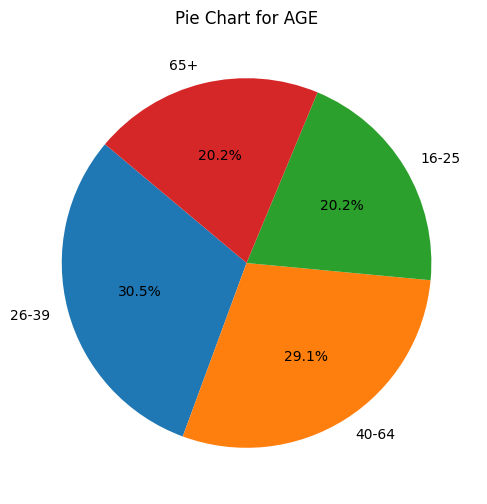

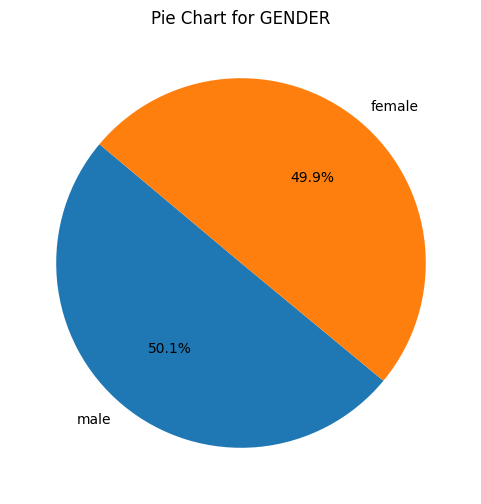

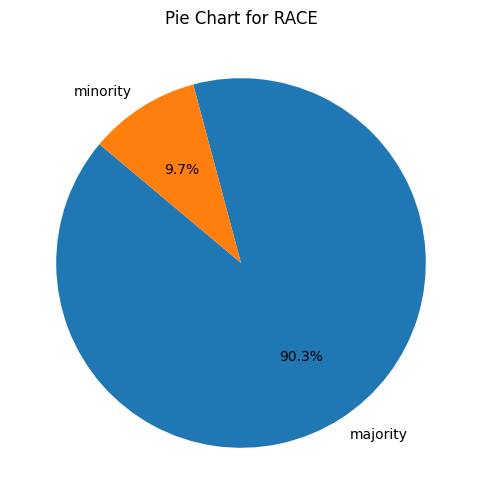

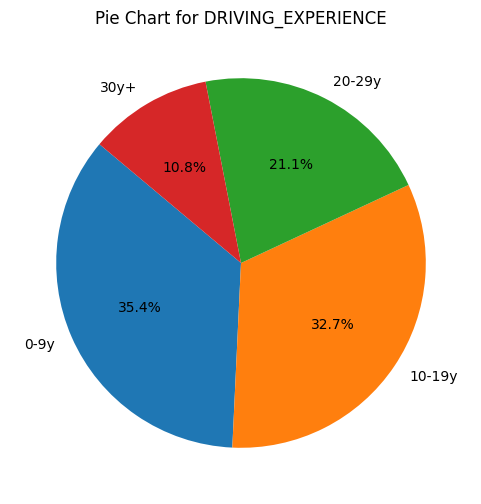

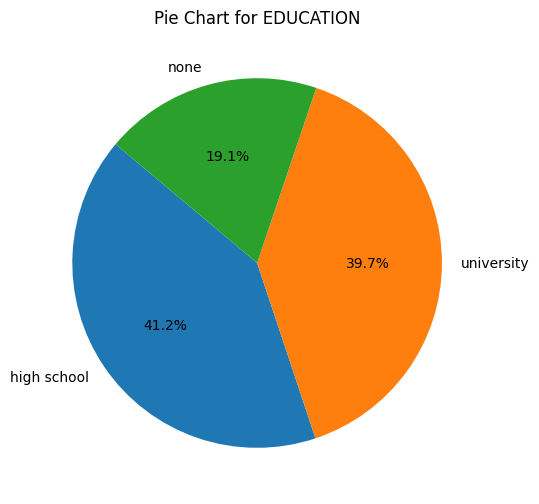

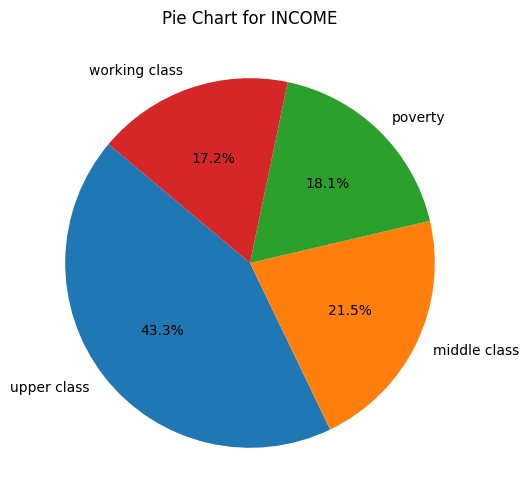

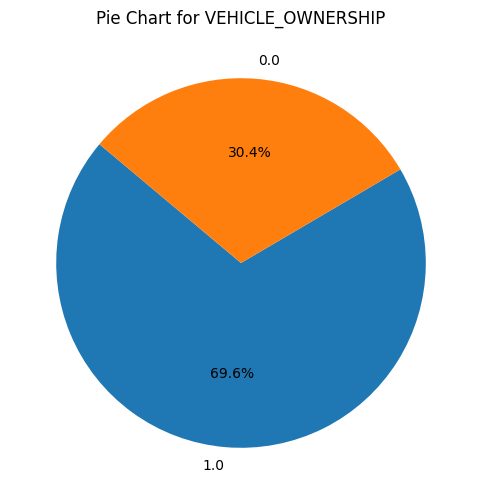

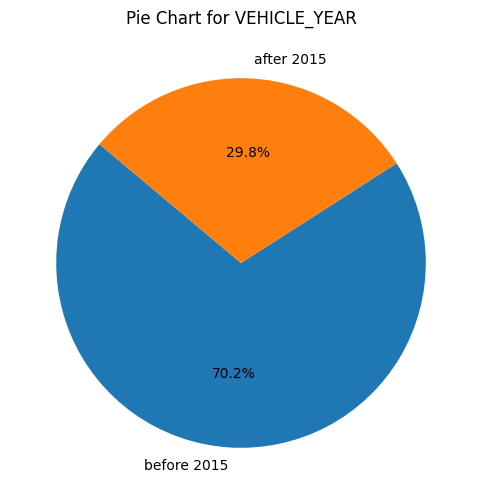

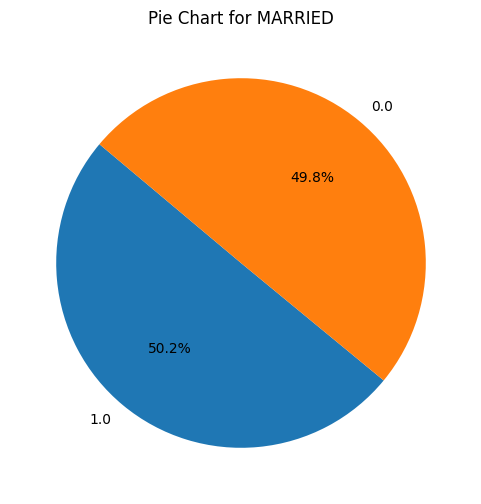

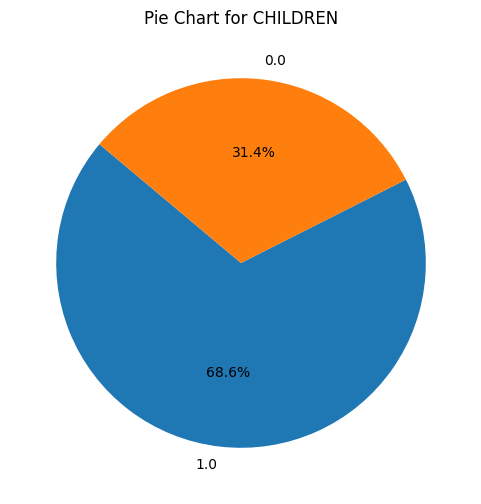

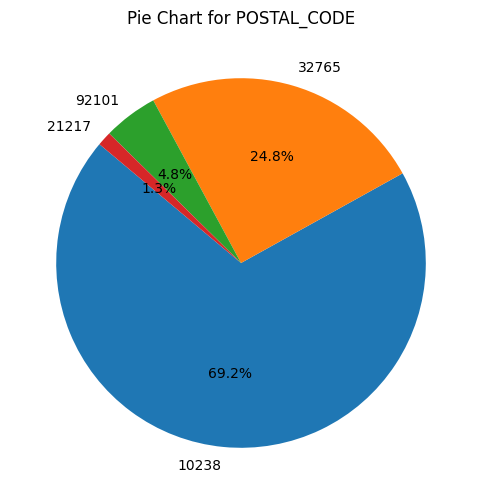

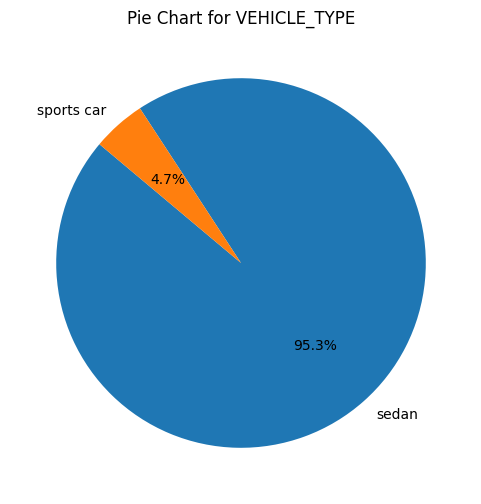

In [87]:
for feature in cat_features:
    counts = df_train[feature].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Pie Chart for {feature}')
    plt.show()

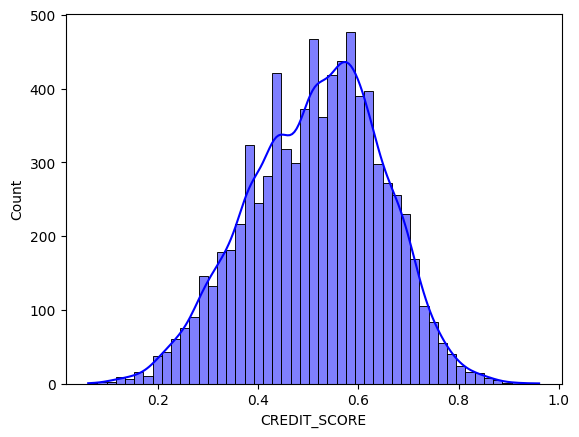

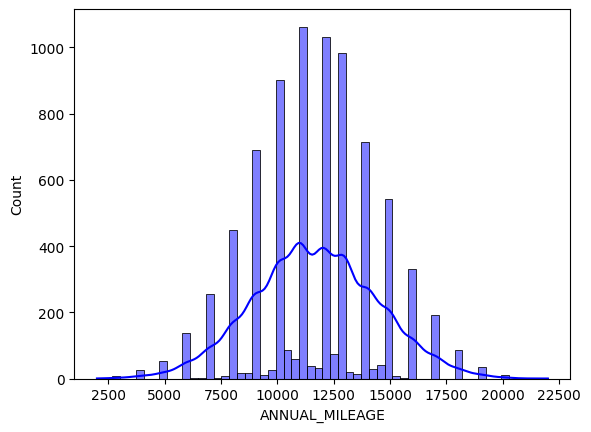

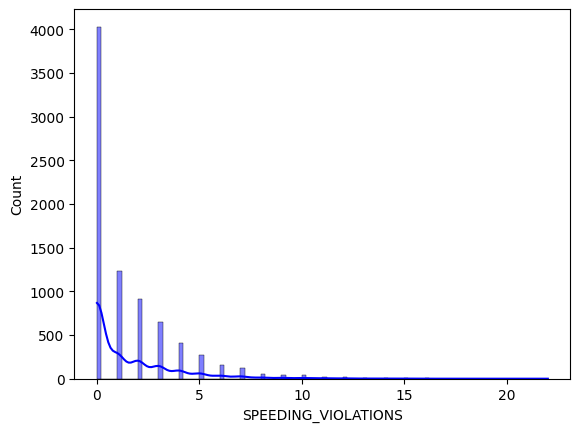

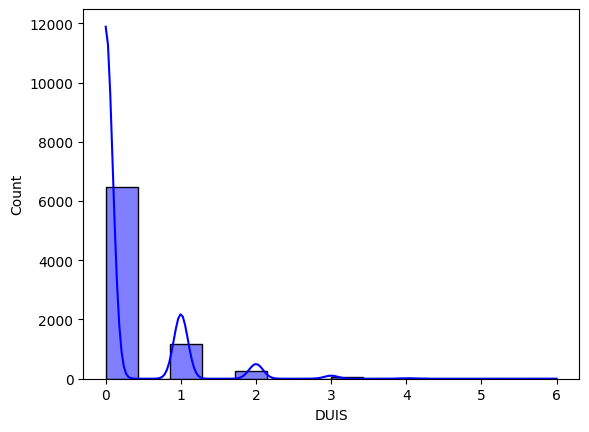

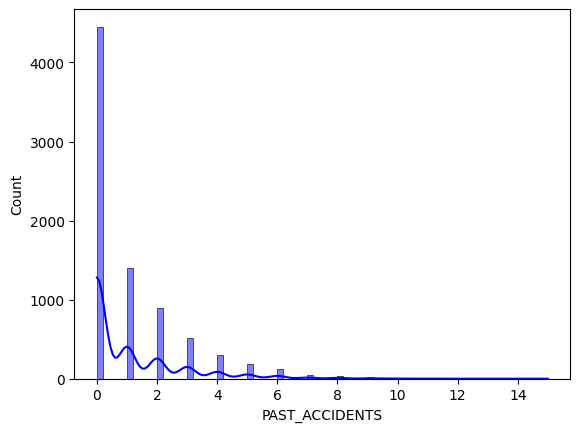

In [88]:
for feature in num_features:
    sns.histplot(
        data = df_train_filled,
        x = feature,
        kde = True,
        color = 'blue'
    )
    plt.show()

<a id="bivariate" ></a>
# Bivariate Analysis

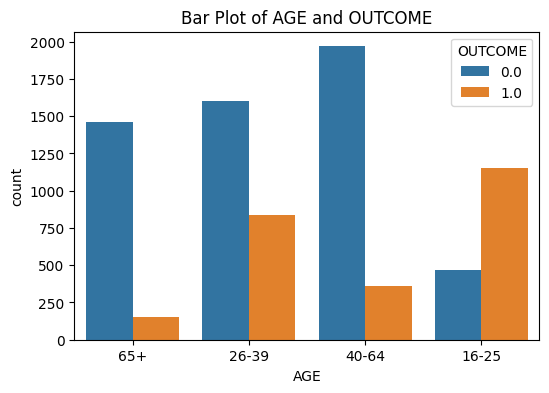

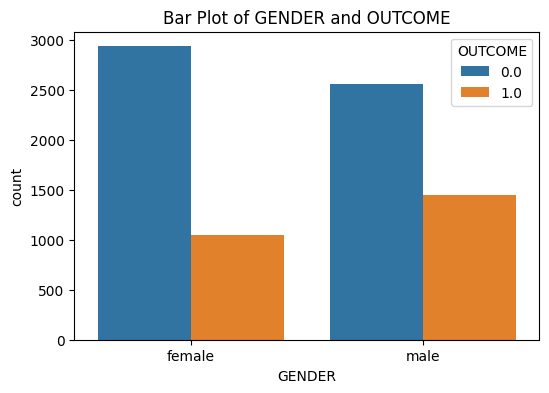

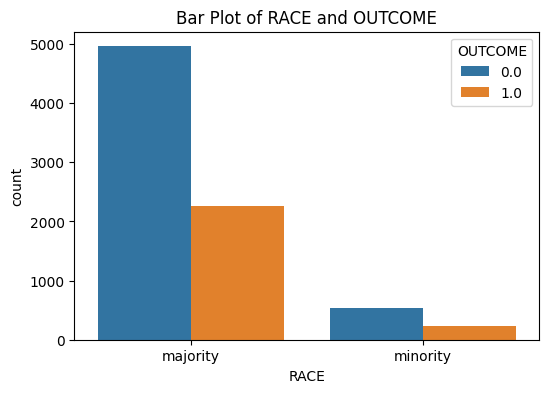

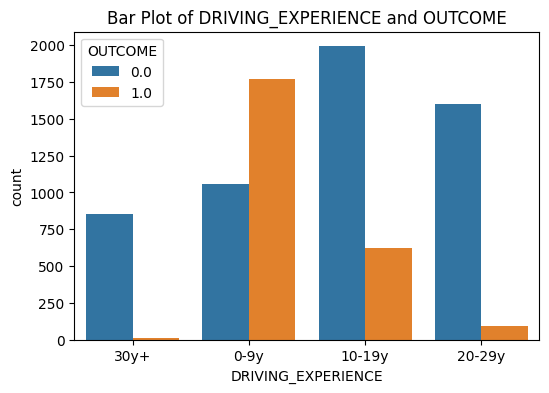

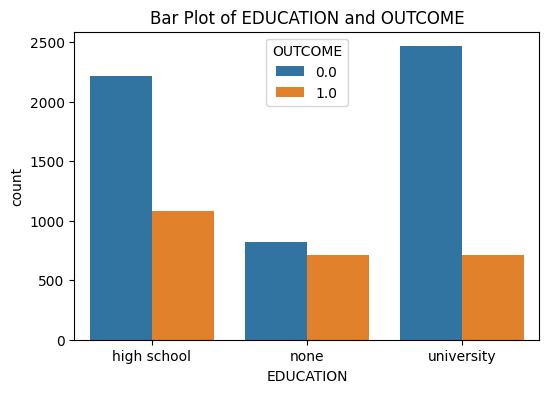

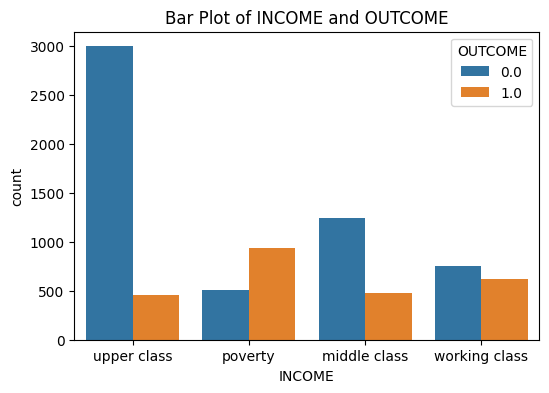

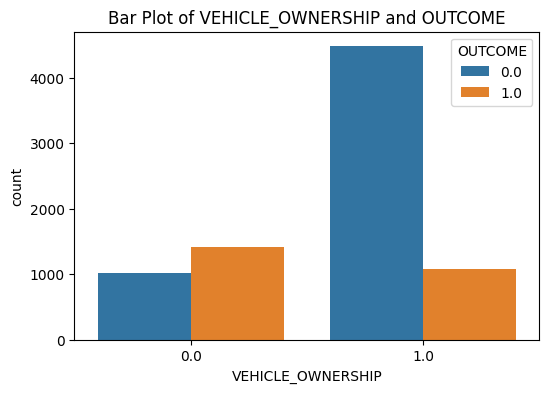

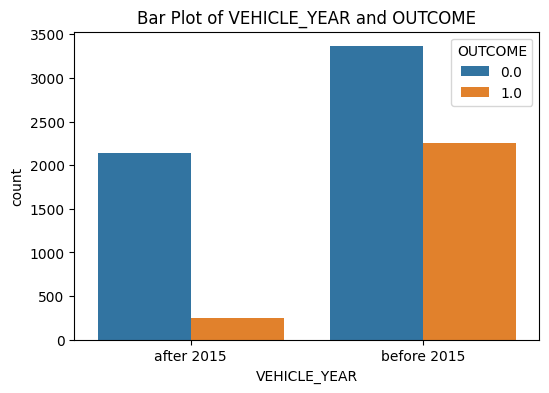

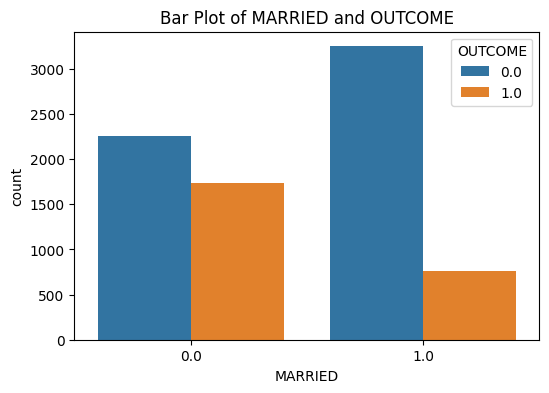

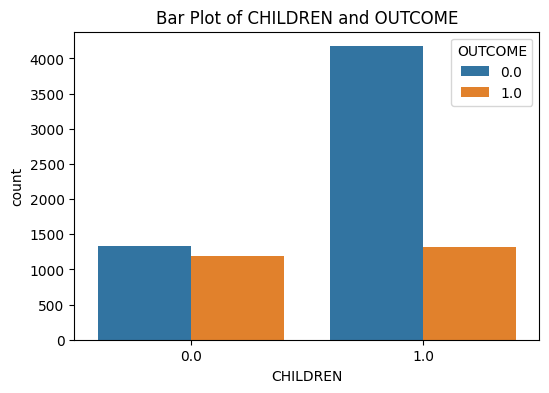

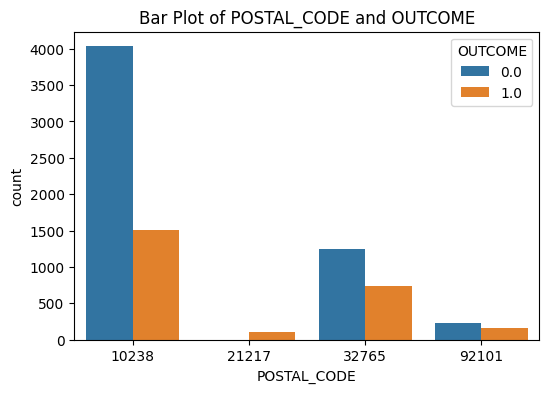

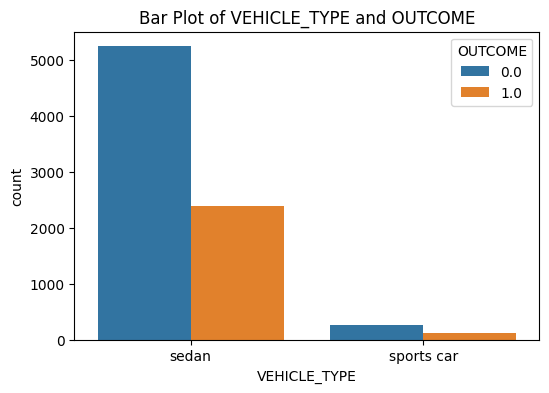

In [89]:
for feature in cat_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=feature, hue='OUTCOME', data=df_train)
    plt.title(f'Bar Plot of {feature} and OUTCOME')
    plt.show()

From the bar charts, we can see that OUTCOME = 0 excels in several cases: 
- elder people ,
- people with 20+ years experience, 
- people with university degree, 
- people in the upper class, 
- people with vehicle, 
- vehicle year from 2015, 
- married people,  
- and people with children

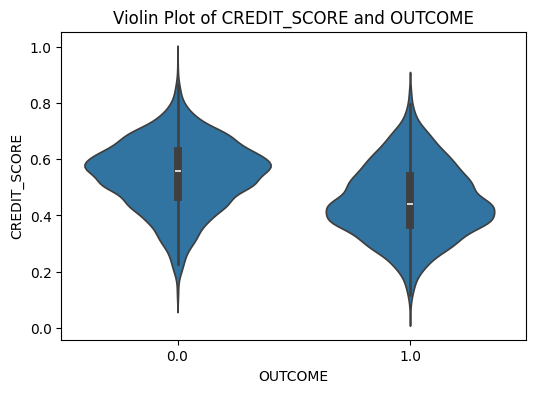

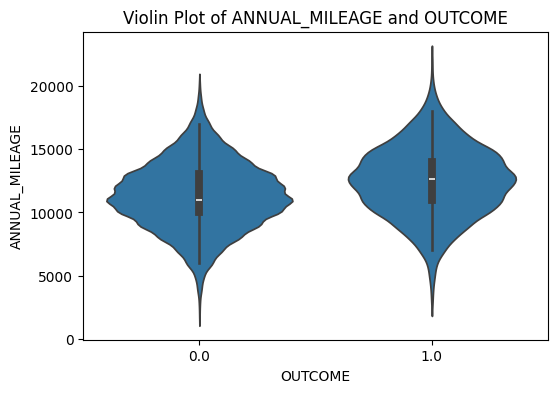

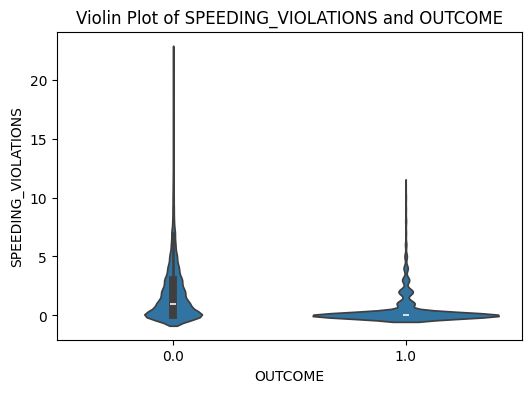

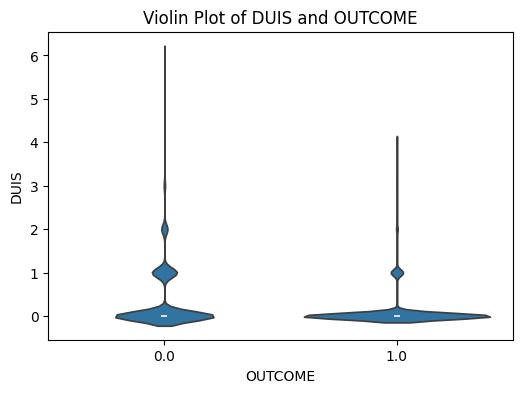

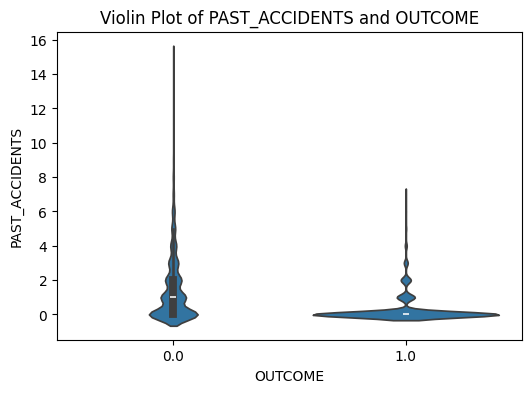

In [90]:
df_train_filled['OUTCOME'] = df_train['OUTCOME']
for feature in num_features:
    plt.figure(figsize=(6, 4))
    sns.violinplot(y=feature,x='OUTCOME', data = df_train_filled)
    plt.title(f'Violin Plot of {feature} and OUTCOME')
    plt.show()

The plot suggests that the OUTCOME category 1.0 is associated with a greater number of PAST_ACCIDENTS than the OUTCOME category 0.0. 

The same conclusion holds for DUIS and SPEEDING_VIOLATIONS

<a id="utilities" ></a>
# Utilities

Before training the model, we will need some utilized functions, for example, model evaluation, cross validation and hypertune

In [91]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [92]:
def model_evaluation(y_true, y_pred):
    # Calculate metrics
    f1 = f1_score(y_true, y_pred, average='binary')
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    accuracy = accuracy_score(y_true, y_pred)
    
    # Print or return the scores
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

def cross_validation(estimator, X, y, score = 'accuracy', n = 5):
    validate = cross_val_score(estimator, X, y, scoring = score, cv = n)
    print("Accuracy mean score: ", validate.mean())
    
# Hypertunning
def hyper_tune(estimator, X, y, param_grid, score = 'accuracy', n = 5):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=score,
        cv=n
    )
    grid_search.fit(X, y)
    best_score = grid_search.best_score_
    print("Best accuracy score: ", best_score)
    return grid_search.best_estimator_

<a id="train-and-validate" ></a>
# LightGBM Model on training and validation data

In [93]:
X_train_val = df_train_filled.drop(columns=['OUTCOME']).values
y_train_val = df_train_filled['OUTCOME'].values

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state = 42)

In [94]:
print(X_train_val.shape)
print(y_train_val.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(8000, 17)
(8000,)
(6000, 17)
(6000,)
(2000, 17)
(2000,)


In [95]:
from lightgbm import LGBMClassifier

In [96]:
gbm = LGBMClassifier(num_leaves = 31, verbose = -1)
cross_validation(gbm, X_train, y_train)

Accuracy mean score:  0.8538333333333334


In [97]:
gbm.fit(X_train, y_train)

LGBMClassifier(verbose=-1)

In [98]:
y_pred = gbm.predict(X_train)
model_evaluation(y_train, y_pred)

F1 Score: 0.8664
Precision: 0.8492
Recall: 0.8844
Accuracy: 0.9132


In [99]:
y_val_pred = gbm.predict(X_val)
model_evaluation(y_val, y_val_pred)

F1 Score: 0.7274
Precision: 0.7104
Recall: 0.7453
Accuracy: 0.8355


Results explained

- A precision of 0.7104 means that about 71% of the instances predicted as positive by the model were actually positive.

- A recall of 0.7453 means the model correctly identified about 74% of all actual positives in the test set.

<a id="prepare-test" ></a>
# Prepare the test set

In order to prepare the test set, we will do the following:
- Use trained encoder to label encode categorical features
- Use saved credit_imp and mileage_imp to fill in missing values of CREDIT_SCORE and ANNUAL_MILEAGE

In [100]:
def label_encoding_test(df, cat_features, encoders):
    df_encoded = df.copy()

    for feature in cat_features:
        # Mapping of known labels to encoded values
        known_labels_map = {label: encoders[feature].transform([label])[0] for label in encoders[feature].classes_}

        # Function to encode a single value
        def encode_value(val):
            if pd.isna(val) or val not in known_labels_map:
                return -1  # Handle unseen labels and NaNs
            else:
                return known_labels_map[val]

        # Apply encoding to the column
        df_encoded[feature] = df[feature].apply(encode_value).astype(int)

    return df_encoded

In [101]:
df_test = label_encoding_test(df_test, cat_features, encoders)

In [102]:
df_test

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
6252,1,0,0,1,0,0,0.541596,0,1,1,1,2,11000.0,0,1,0,0,1.0
4684,3,0,0,2,0,2,0.553462,1,1,1,0,0,8000.0,0,3,1,4,0.0
1731,0,0,1,0,1,1,0.245740,0,1,0,0,2,13000.0,0,0,0,0,1.0
4742,0,1,0,0,1,1,NaN,1,1,0,0,0,14000.0,0,0,0,0,1.0
4521,2,0,0,2,2,2,0.689458,1,0,1,1,0,10000.0,1,2,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,0,0,0,0,2,0,0.769243,1,1,0,0,0,17000.0,0,0,0,0,1.0
8285,2,1,0,2,0,0,0.605015,1,1,0,0,0,15000.0,0,0,1,1,0.0
7853,2,1,0,1,1,3,0.517708,1,1,1,1,0,12000.0,0,1,0,3,0.0
1095,1,0,0,1,1,1,0.344072,1,1,0,1,0,15000.0,0,0,0,2,0.0


In [103]:
df_test.isna().sum()

AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           192
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         187
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [104]:
def credit_fill_test(df, imputer, features, column):
    X_missing = df.loc[df[column].isna(), features]
    y_pred = imputer.predict(X_missing)
    df.loc[df[column].isna(), column] = y_pred
    print(f'Imputation completed for {column} on test set')

In [105]:
credit_fill_test(df_test, credit_imp, credit_features, 'CREDIT_SCORE')

Imputation completed for CREDIT_SCORE on test set


In [106]:
def mileage_fill_test(df, imputer, column):
    X_missing = df.loc[df[column].isna()].drop(column, axis=1)
    y_pred = imputer.predict(X_missing)
    df.loc[df[column].isna(), column] = y_pred
    print(f'Imputation completed for {column} on the test set')

In [107]:
df_test_no_outcome = df_test.drop(columns = ['OUTCOME'], axis=1)
mileage_fill_test(df_test_no_outcome, mileage_imp, 'ANNUAL_MILEAGE')

Imputation completed for ANNUAL_MILEAGE on the test set


In [108]:
df_test_no_outcome.isna().sum()

AGE                    0
GENDER                 0
RACE                   0
DRIVING_EXPERIENCE     0
EDUCATION              0
INCOME                 0
CREDIT_SCORE           0
VEHICLE_OWNERSHIP      0
VEHICLE_YEAR           0
MARRIED                0
CHILDREN               0
POSTAL_CODE            0
ANNUAL_MILEAGE         0
VEHICLE_TYPE           0
SPEEDING_VIOLATIONS    0
DUIS                   0
PAST_ACCIDENTS         0
dtype: int64

<a id="model-on-test" ></a>
# LGBM on test set

In [109]:
X_test = df_test_no_outcome.values 
y_test = df_test['OUTCOME'].values

In [110]:
y_pred = gbm.predict(X_test)
model_evaluation(y_test, y_pred)

F1 Score: 0.7578
Precision: 0.7670
Recall: 0.7488
Accuracy: 0.8485


<a id="hypertune" ></a>
# Hypertuning

We will hypertune LGBM model for the best result.

In [112]:
param_grid = {
    'num_leaves': [25, 31 ,40],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [80, 100, 120],
    'verbose': [-1]
}

best_gbm = hyper_tune(gbm, X_val, y_val, param_grid)

Best accuracy score:  0.8305


In [113]:
best_gbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, num_leaves=25, verbose=-1)

In [114]:
y_pred = best_gbm.predict(X_test)
model_evaluation(y_test, y_pred)

F1 Score: 0.7663
Precision: 0.7712
Recall: 0.7615
Accuracy: 0.8530


<a id="features" ></a>
# Important features

With LGBM and other tree-based methods, we can extract important features

In [115]:
lst = df_train_filled.drop(columns=['OUTCOME']).columns.to_list()

def get_important_features(best_clf, top_n):
    
    # Get feature importances
    importance = best_clf.feature_importances_

    # Get indices of sorted importances
    sorted_indices = np.argsort(importance)[::-1]
    
    top_n_features = [lst[index] for index in sorted_indices[:top_n]]
    print(f"Top {top_n} important features: ", top_n_features)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_indices)), importance[sorted_indices], align='center')
    plt.yticks(range(len(sorted_indices)), importance)
    plt.xlabel("Feature Importance")
    plt.title("Feature Importances in Classifier Model")
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
    plt.show()

Top 5 important features:  ['CREDIT_SCORE', 'POSTAL_CODE', 'ANNUAL_MILEAGE', 'DRIVING_EXPERIENCE', 'GENDER']


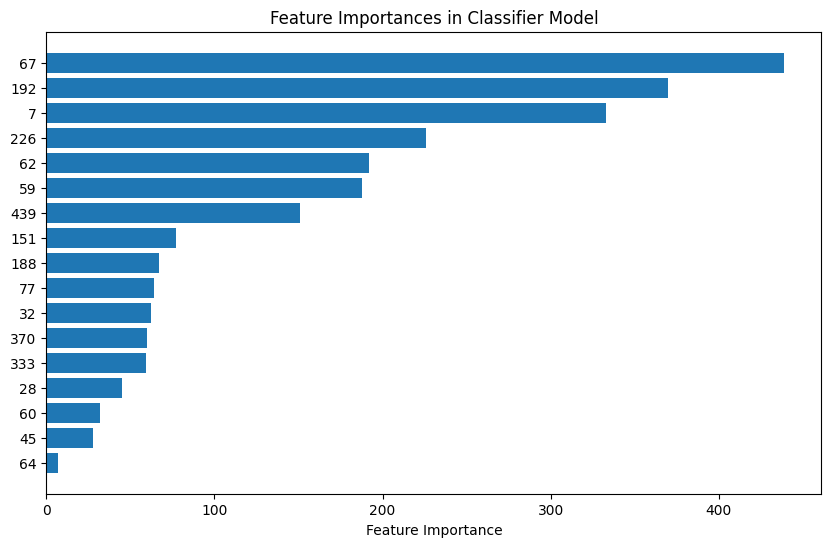

In [116]:
# Top 5 important features
get_important_features(best_gbm, top_n=5)

For Light GBM, there are two types of importance:

Split importance: This is the number of times a feature is used in a model. In this case, a higher number would mean that the model uses that feature more often to make splits.

Gain importance: This measures the total gain of the feature when it is used in trees of the model. "Gain" is a measure of the contribution of each feature to the model, with respect to how much it helps to improve the performance measure (like reducing the loss function).

And for the result, we are using split importance, and the higher value a feature has, the more important it is.

<a id="conclusion" ></a>
# Conclusion

LightGBM is a good model for this problem. Top 5 important features for the OUTCOME prediction is: ['CREDIT_SCORE', 'POSTAL_CODE', 'ANNUAL_MILEAGE', 'DRIVING_EXPERIENCE', 'GENDER']
